In [1]:
import os
import requests
import torch

from src.tokenizer import CharTokenizer

__file__='shakespeare_data/'

# download the tiny shakespeare dataset
input_file_path = os.path.join(os.path.dirname(__file__), 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)


#create the tokenizer
tokenizer=CharTokenizer(input_file_path)
print('tokenizer vocab size:', tokenizer.vocab_size)


length of dataset in characters: 1,115,394
tokenizer vocab size: 65


In [2]:
# load the data
with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")


# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = tokenizer(train_data)
val_ids = tokenizer(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
torch.save(train_ids, os.path.join(os.path.dirname(__file__), 'train.bin'))
torch.save(val_ids,   os.path.join(os.path.dirname(__file__), 'val.bin'))

length of dataset in characters: 1,115,394
train has 1,003,854 tokens
val has 111,540 tokens


In [3]:
import torch
from torch import nn
from IPython.display import clear_output

from src.encoder import Encoder, GPT2Encoder
from src.decoder import Decoder, GPT2Decoder
from src.graph_initialization import random_unidirectional_graph_maker, linear_unidirectional_graph_maker
from src.graphAN import GraphAttentionNetwork, BlockGenerator
from src.data_loader import validation
from src.tokenizer import Tokenizer
from src.GPT2 import GPT2_Block, GPT2
from matplotlib import pyplot as plt
from src.utils import moving_average, grad_norm
from torch.nn.utils import clip_grad_norm_
import pickle
import numpy as np


In [5]:
device = 'cpu'
#device = 'mps'  if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device

dK = 16
dV = 16
heads = 6
d_Embedding = dK*heads
intermediate_size=intermediate_size=2*d_Embedding


encoder = Encoder(d_Embedding, tokenizer, dropout=0, device=device)
decoder = Decoder(encoder)
block_generator = BlockGenerator(GPT2_Block, d_Embedding, dK, dV, heads, intermediate_size,
                                 dropout=0.1, split_size=2**10, device=device, rotary_encoding=True)

model = GraphAttentionNetwork(tokenizer, encoder, block_generator, decoder)
model.losses = []
model.validation_losses = []

#model.load('shakespeare_data/pretrained_CE=1.3.pth')


graph_maker = linear_unidirectional_graph_maker(50, device=device)

In [6]:
from src.decoder import Loss

loss_function = Loss(decoder)
ce_loss = nn.CrossEntropyLoss()

lr = 8e-4
gamma = 0.99

grad_norms = []

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

In [7]:
from numpy.random import randint
def sample_shakespeare(data, lenght, starting_index=None):
    lenght=int(lenght)
    
    if starting_index is None:
        starting_index = randint(0, len(data)-lenght)

    if starting_index+lenght>=len(data):
        return data[starting_index:]    
    
    return data[starting_index:starting_index+lenght]


Validation loss: 1.56


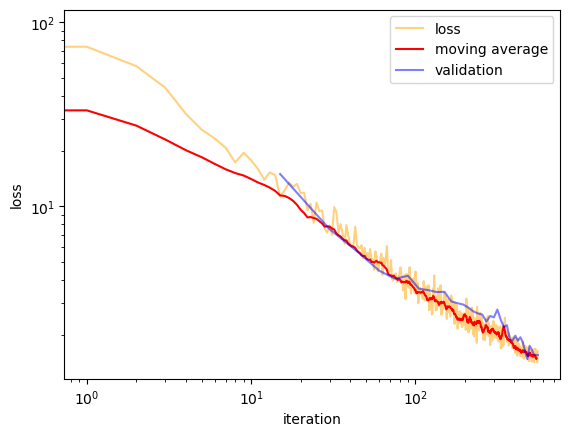

N:555000/1003854, tokens:4999, loss:1.57
grad_norm:2.53
N:556000/1003854, tokens:4999, loss:1.69
grad_norm:2.49
N:557000/1003854, tokens:4999, loss:1.64
grad_norm:2.36
N:558000/1003854, tokens:4999, loss:1.62
grad_norm:2.31
N:559000/1003854, tokens:4999, loss:1.68
grad_norm:2.11
N:560000/1003854, tokens:4999, loss:1.57
grad_norm:2.12
N:561000/1003854, tokens:4999, loss:1.63
grad_norm:2.29
N:562000/1003854, tokens:4999, loss:1.62


KeyboardInterrupt: 

In [8]:
#@title {vertical-output: true}
#@markdown # Training
#@markdown the loss function is cross entropy ❌🎲

n_epochs = int(1e6)
model.train()
context_size=2e2

for i in range(n_epochs):

    
    inp=sample_shakespeare(train_ids, context_size)

    nodes=inp[:-1]
    target=inp[1:]
    edge_index = graph_maker(nodes.shape[0])
    prediction = model(nodes, edge_index)
    loss = loss_function(prediction, target)

    print(f'N:{int(i*1e3)}/{len(train_ids)}, tokens:{nodes.shape[0]}, loss:{loss.item():.2f}')
    model.losses.append(loss.item())
    loss.backward()

    gn = grad_norm(model)
    print(f'grad_norm:{gn:.2f}')
    grad_norms.append(gn)
    clip_grad_norm_(model.parameters(), 4*loss.item())

    optimizer.step()
    optimizer.zero_grad()  # reinitialize the gradient to zero

    if i%15==14:
        clear_output()
        scheduler.step()

        m_av = moving_average(model.losses, 10)
        model.best_loss = min(m_av)

        if model.best_loss<2:
            context_size=1e3

        if model.best_loss<1.5:
            context_size=5e3

        inp=sample_shakespeare(val_ids, 1e3)
        nodes=inp[:-1]
        target=inp[1:]
        edge_index = graph_maker(nodes.shape[0])
        prediction = model(nodes, edge_index)
        validation_loss = loss_function(prediction, target)

        model.validation_losses.append(validation_loss.item())

        print(f'Validation loss: {validation_loss:.2f}')

        plt.plot(model.losses, label='loss', color='orange', alpha=0.5)
        plt.plot(m_av, label='moving average', color='red')
        plt.plot(np.arange(len(model.validation_losses))*15+15, model.validation_losses, label='validation',color='blue',alpha=0.5)

        plt.legend()
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.yscale('log')
        plt.xscale('log')
        plt.show()


In [25]:
model.eval()
text=sample_shakespeare(val_data, 100)
text=tokenizer(text)

x=text[:-1]
target=text[1:]
edge_index=graph_maker(x.shape[0])

prediction=model.calculate_final_embedding(x,edge_index)


print(ce_loss(prediction,target).item())

print(loss_function(model(x,edge_index),target).item())

1.5944961309432983
1.5944961309432983


In [19]:
print(generated_text)

?

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, d,
DHis,
Butout,
ICKSARClitrece d wUnd thespe, to l you NGEIker linutaremy for.



Wimb ar rfie.
Bu 


In [14]:
a=torch.tensor(1)
b=torch.tensor([1,2,3,5])

a
#torch.cat((b,a))

tensor(1)

In [7]:
target = x[1:]
prediction = x[:-1]

edge_index = graph_maker(prediction.shape[0])

prediction = model(prediction, edge_index)
loss_function(prediction, target)

/Users/francescosacco/Documents/Github/Language_CA/src/attention.py:122: UserWarning: scatter_reduce() is in beta and the API may change at any time. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525473998/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1615.)
  translation = translation.scatter_reduce(0, receivers.repeat(heads, 1).t(), att, reduce='amax', include_self=False)


NameError: name 'loss_function' is not defined

In [106]:
from torch.nn import Softmax

sm=Softmax(-1)

In [86]:
print(text)

?

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and v


In [87]:
print(generated_text)


?

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and ving t went the wing t wen tereee ofereeereeen omeence are allind and and and ane and ane ser sencese
